# Aprendizagem Automática - Assignment 1 

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models and selection methods
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

# Binary classifier metrics
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

# Linear regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr

def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

Importação do dataset parkinsons

In [3]:
parkinsons_data = pd.read_csv("parkinsons_updrs.data")
parkinsons_data

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,22.485,33.485,0.00406,0.000031,0.00167,0.00168,...,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.8400,21.988,32.988,0.00297,0.000025,0.00119,0.00147,...,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.8200,21.495,32.495,0.00349,0.000025,0.00152,0.00187,...,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.7300,21.007,32.007,0.00281,0.000020,0.00128,0.00151,...,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


## Objective 1
Preparação do dataset

In [4]:
# Copiar o dataframe original
parkinsons_objective1 = parkinsons_data.copy()

# Remover a coluna total_UPDRS e subject#
parkinsons_objective1.drop(columns=["subject#","total_UPDRS"], inplace=True)

# Divisão do dataset em variaveis independentes e dependentes
X_obj1 = parkinsons_objective1[set(parkinsons_objective1.columns) - {"motor_UPDRS"}]
y_obj1 = parkinsons_objective1["motor_UPDRS"]

# Converter para np array
Xc_obj1 = X_obj1.to_numpy()
yc_obj1 = y_obj1.to_numpy()

# Divisão do dataset em training set e independent validation set
X_obj1_TRAIN, X_obj1_IVS, y_obj1_TRAIN, y_obj1_IVS = train_test_split(Xc_obj1, yc_obj1, test_size=0.10, random_state=314)

### Fitting e validação dos modelos

N-Fold split

In [5]:
kf1 = KFold(n_splits=16, shuffle=True, random_state = 274)
kf1.get_n_splits(X_obj1_TRAIN)

16

##### Decision Tree Regressor

N-Cross validation

In [6]:
# NOTA: é preciso fazer isto para diferentes hyperparameters e guardar
#       as metricas para cada um, assim podemos comparar depois e determinar
#       qual os melhores hyperparameters antes de validarmos o modelo com os
#       dados IVS. Depois de fazermos isto para o decision tree regressor, temos
#       de o fazer para o linear regressor que vamos dar na aula de amanha

In [7]:
TRUTH=None
PREDS=None


for train_index, test_index in kf1.split(X_obj1_TRAIN):
    X_train, X_test = X_obj1_TRAIN[train_index], X_obj1_TRAIN[test_index]
    y_train, y_test = y_obj1_TRAIN[train_index], y_obj1_TRAIN[test_index]
    dtr_obj1 = DecisionTreeRegressor()
    dtr_obj1.fit(X_train, y_train)
    preds = dtr_obj1.predict(X_test)
    if TRUTH is None:
        PREDS=preds
        TRUTH=y_test
    else:
        PREDS=np.hstack((PREDS, preds))
        TRUTH=np.hstack((TRUTH, y_test))
        


In [8]:
    printRegStatistics(TRUTH,PREDS)

The RVE is:  0.9135783283527059
The rmse is:  2.3918429824749055
The Correlation Score is is: 0.9567 (p-value=0.000000e+00)

The Maximum Error is is:  27.676000000000002
The Mean Absolute Error is:  0.7060779837336865


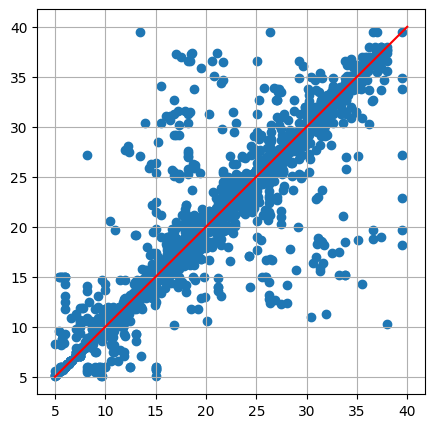

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(PREDS, TRUTH)
plt.plot((5, 40), (5,40), c="r")
plt.grid()
plt.show()

## Modelos Lineares

Regressão Linear

The bias is:  30.890403756468015
The other parameters are: 
	 B1 ->  3373.374
	 B2 ->   -12.944
	 B3 ->  8709.602
	 B4 ->     0.192
	 B5 ->    -1.358
	 B6 ->  -106.013
	 B7 ->  -670.162
	 B8 ->   201.912
	 B9 ->   778.739
	 B10 ->     0.607
	 B11 ->    -0.457
	 B12 ->    -9.604
	 B13 ->   -23.138
	 B14 -> -10346.487
	 B15 -> -25920.666
	 B16 ->     0.012
	 B17 ->    58.704
	 B18 -> -88332.472
	 B19 ->    16.644
The RVE is:  0.0414280091438618
The rmse is:  7.8916791571722005
The Correlation Score is is: 0.2858 (p-value=1.627410e-12)

The Maximum Error is is:  51.80489751239841
The Mean Absolute Error is:  6.485911856732683


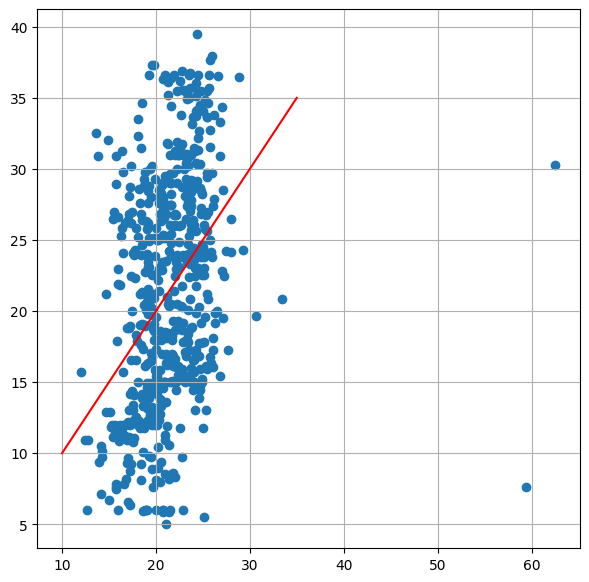

In [28]:
reg = LinearRegression().fit(X_obj1_TRAIN, y_obj1_TRAIN)  #Obtivemos a mesma coisa que anteriormente
#reg.score(X_train, y_train)

print("The bias is: ",  reg.intercept_)
print("The other parameters are: ")
for i, beta in enumerate(reg.coef_):
    print("\t B%d -> %9.3f"% (i+1, beta))

preds=reg.predict(X_obj1_IVS)
printRegStatistics(y_obj1_IVS,preds)

plt.figure(figsize=(7,7))
plt.scatter(preds, y_obj1_IVS)
plt.grid()
plt.plot([10,35], [10,35], c="r")
plt.show()

Ridge

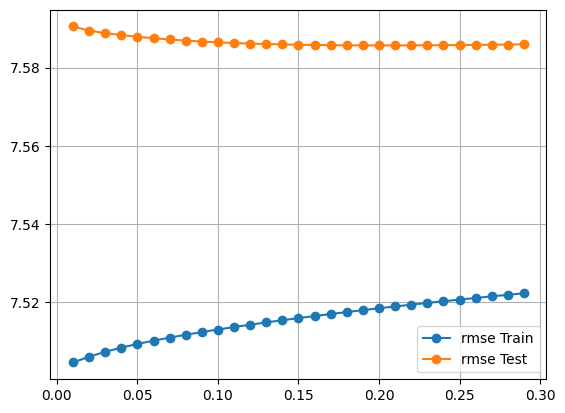

In [18]:
rmse_train = []
rmse_test = []
alphas=[0.01*i for i in range(1,30)]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000).fit(X_obj1_TRAIN, y_obj1_TRAIN)
    preds_tr=ridge.predict(X_obj1_TRAIN)
    preds_te=ridge.predict(X_obj1_IVS)
    rmse_train.append(mean_squared_error(y_obj1_TRAIN, preds_tr, squared=False))
    rmse_test.append(mean_squared_error(y_obj1_IVS, preds_te, squared=False))
    
plt.plot(alphas, rmse_train, label="rmse Train", marker='o')    
plt.plot(alphas, rmse_test, label="rmse Test", marker='o')    
plt.grid()
plt.legend()
plt.show() #O melhor alpha é 0.2


In [22]:
#Então agora usamos o ridge para alpha=0.2

ridge = Ridge(alpha=0.2, max_iter=9999999).fit(X_obj1_TRAIN, y_obj1_TRAIN)  #Em alpha=10, estamos overpenalizing

print("The bias is: ",  ridge.intercept_)
print("The other parameters are: ")
for i, beta in enumerate(ridge.coef_):
    print("\t B%02d -> %9.3f"% (i+1, beta))

preds=ridge.predict(X_obj1_IVS)
printRegStatistics(y_obj1_IVS, preds)

The bias is:  31.265026749497245
The other parameters are: 
	 B01 ->   -39.002
	 B02 ->   -17.219
	 B03 ->    15.431
	 B04 ->     0.197
	 B05 ->    -0.288
	 B06 ->   -10.136
	 B07 ->     4.227
	 B08 ->     8.493
	 B09 ->     8.232
	 B10 ->    -0.423
	 B11 ->    -0.405
	 B12 ->     1.077
	 B13 ->   -25.566
	 B14 ->   -13.002
	 B15 ->     5.137
	 B16 ->     0.011
	 B17 ->    45.782
	 B18 ->    -0.282
	 B19 ->    13.343
The RVE is:  0.1145029450099061
The rmse is:  7.585693033652075
The Correlation Score is is: 0.3401 (p-value=2.196446e-17)

The Maximum Error is is:  20.00275865191518
The Mean Absolute Error is:  6.433933185474149


LASSO

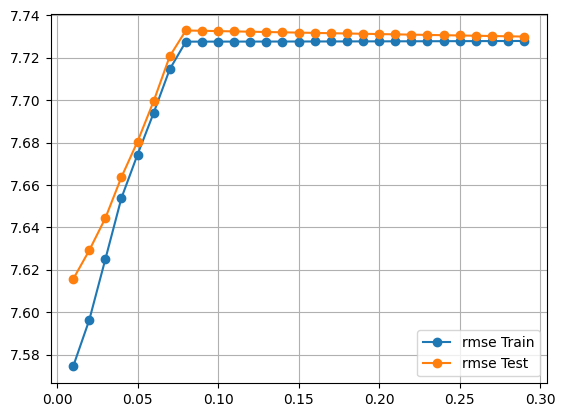

In [26]:
rmse_train = []
rmse_test = []
alphas=[0.01*i for i in range(1,30)]
for alpha in alphas:
    L = Lasso(alpha=alpha, max_iter=100000).fit(X_obj1_TRAIN, y_obj1_TRAIN)
    preds_tr=L.predict(X_obj1_TRAIN)
    preds_te=L.predict(X_obj1_IVS)
    rmse_train.append(mean_squared_error(y_obj1_TRAIN, preds_tr, squared=False))
    rmse_test.append(mean_squared_error(y_obj1_IVS, preds_te, squared=False))
    
plt.plot(alphas, rmse_train, label="rmse Train",marker='o')    
plt.plot(alphas, rmse_test, label="rmse Test",marker='o')    
plt.grid()
plt.legend()
plt.show() # o melhor alpha é 0.08


In [27]:
#E agora aplicamos o LASSO para alfa=0.08

L = Lasso(alpha=0.08, max_iter=9999999).fit(X_obj1_TRAIN, y_obj1_TRAIN)
preds=L.predict(X_obj1_IVS)
printRegStatistics(y_obj1_IVS, preds)

The RVE is:  0.08004407934004554
The rmse is:  7.732924177256134
The Correlation Score is is: 0.2851 (p-value=1.848780e-12)

The Maximum Error is is:  18.54930341151541
The Mean Absolute Error is:  6.642987937840032


## Objective 2
Preparação do dataset

In [30]:
# Copiar o dataframe original
parkinsons_objective2 = parkinsons_data.copy()
# Remover a coluna subject# e motor_UPDRS
parkinsons_objective2.drop(columns=["subject#","motor_UPDRS"], inplace=True)
# Transformação de total_UPDRS em variavel binaria
parkinsons_objective2["total_UPDRS"] = parkinsons_objective2["total_UPDRS"].apply(lambda x : 1 if x > 40 else 0)

X_obj2 = parkinsons_objective2[set(parkinsons_objective2.columns) - {"total_UPDRS"}]
y_obj2 = parkinsons_objective2["total_UPDRS"]

# Converter para np array
Xc_obj2 = X_obj2.to_numpy()
yc_obj2 = y_obj2.to_numpy()

# Divisprint(y_obj2)ão do dataset em training set e independent validation set
X_obj2_TRAIN, X_obj2_IVS, y_obj2_TRAIN, y_obj2_IVS = train_test_split(Xc_obj2, yc_obj2, test_size=0.10, random_state=314)

### Fitting e validação dos modelos

N-Fold Split

In [31]:
kf2 = KFold(n_splits=16, shuffle=True, random_state = 274)
kf2.get_n_splits(X_obj2_TRAIN)

16

##### Decision Tree Classifier

N-Cross validation

In [ ]:
# NOTA: é preciso fazer isto para diferentes hyperparameters e guardar
#       as metricas para cada um, assim podemos comparar depois e determinar
#       qual os melhores hyperparameters antes de validarmos o modelo com os
#       dados IVS. 
#       Para além disto, devemos testar tanto com um critério de entropia,
#       bem como de Gini.

# Exemplos: min_samples_leaf, max_depth...

In [32]:
TRUTH=None
PREDS=None

for train_index, test_index in kf1.split(X_obj1_TRAIN):
    X_train, X_test = X_obj2_TRAIN[train_index], X_obj2_TRAIN[test_index]
    y_train, y_test = y_obj2_TRAIN[train_index], y_obj2_TRAIN[test_index]
    
    dtr_obj2 = DecisionTreeClassifier()
    dtr_obj2.fit(X_train, y_train)
    
    preds = dtr_obj2.predict(X_test)
    if TRUTH is None:
        PREDS=preds
        TRUTH=y_test
    else:
        PREDS=np.hstack((PREDS, preds))
        TRUTH=np.hstack((TRUTH, y_test))

In [ ]:
printRegStatistics(TRUTH,PREDS)

The RVE is:  0.9374706116304944
The rmse is:  0.09428536220034696
The Correlation Score is is: 0.9686 (p-value=0.000000e+00)

The Maximum Error is is:  1
The Mean Absolute Error is:  0.008889729525250615
